In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Previous Model Construction

In [2]:
root='/kaggle/input/d/denizkavi1/brain-tumor/'
data={}
for class_ in os.listdir(root):
    for image in os.listdir(root+class_):
        data[root+class_+'/'+image]=class_
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data['class_']=data['class_'].map({ '1': 'meningioma', '2': 'glioma', '3':'pituitary', })
data
data

,path,class_
2819,/kaggle/input/d/denizkavi1/brain-tumor/1/2819.png,meningioma
464,/kaggle/input/d/denizkavi1/brain-tumor/2/683.png,glioma
1935,/kaggle/input/d/denizkavi1/brain-tumor/3/1800.png,pituitary
1007,/kaggle/input/d/denizkavi1/brain-tumor/2/53.png,glioma
2102,/kaggle/input/d/denizkavi1/brain-tumor/3/1387.png,pituitary
...,...,...
1261,/kaggle/input/d/denizkavi1/brain-tumor/2/537.png,glioma
1910,/kaggle/input/d/denizkavi1/brain-tumor/3/2237.png,pituitary
272,/kaggle/input/d/denizkavi1/brain-tumor/2/1113.png,glioma
2244,/kaggle/input/d/denizkavi1/brain-tumor/3/1397.png,pituitary


In [3]:
n=len(data)
train_last=int(0.7*n)
valid_last=int(0.8*n)
train=data[:train_last]
validation=data[train_last:valid_last]
test=data[valid_last:]
test =pd.read_csv('/kaggle/input/brain-tumor/preprocessed/test.csv')
test

,path,class_
0,/kaggle/input/brain-tumor/2/241.png,glioma
1,/kaggle/input/brain-tumor/1/2649.png,meningioma
2,/kaggle/input/brain-tumor/2/1292.png,glioma
3,/kaggle/input/brain-tumor/3/2216.png,pituitary
4,/kaggle/input/brain-tumor/3/1027.png,pituitary
...,...,...
608,/kaggle/input/brain-tumor/2/792.png,glioma
609,/kaggle/input/brain-tumor/2/28.png,glioma
610,/kaggle/input/brain-tumor/2/678.png,glioma
611,/kaggle/input/brain-tumor/2/652.png,glioma


In [4]:
test["path"]=test['path'].apply(lambda x: '/kaggle/input/d/denizkavi1/brain-tumor/'+x.split('/')[-2] +'/'+ x.split('/')[-1])

In [5]:
test

,path,class_
0,/kaggle/input/d/denizkavi1/brain-tumor/2/241.png,glioma
1,/kaggle/input/d/denizkavi1/brain-tumor/1/2649.png,meningioma
2,/kaggle/input/d/denizkavi1/brain-tumor/2/1292.png,glioma
3,/kaggle/input/d/denizkavi1/brain-tumor/3/2216.png,pituitary
4,/kaggle/input/d/denizkavi1/brain-tumor/3/1027.png,pituitary
...,...,...
608,/kaggle/input/d/denizkavi1/brain-tumor/2/792.png,glioma
609,/kaggle/input/d/denizkavi1/brain-tumor/2/28.png,glioma
610,/kaggle/input/d/denizkavi1/brain-tumor/2/678.png,glioma
611,/kaggle/input/d/denizkavi1/brain-tumor/2/652.png,glioma


In [6]:
batch_size=32
size=224 #image size
epoch=20

In [7]:
def roi_select(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,thresholded = cv2.threshold(grayscale, 0, 255, cv2.THRESH_OTSU)
    bbox = cv2.boundingRect(thresholded)
    x, y, w, h = bbox
    foreground = img[y:y+h, x:x+w]
    return foreground
def apply_adaptive_histogram_equalization(image, clip_limit=2.0, grid_size=(8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    ahe_image = clahe.apply(gray_image)
    ahe_image_rgb = cv2.cvtColor(ahe_image, cv2.COLOR_GRAY2RGB)
    return ahe_image_rgb

def preprocess(img):
    img = img.astype("uint8")
    img=apply_adaptive_histogram_equalization(roi_select(img))/255.0
    return tf.image.resize(img,(size,size)).numpy()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
)
test_images = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Found 613 validated image filenames belonging to 3 classes.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

Found 2144 validated image filenames belonging to 3 classes.


In [10]:

def non_local_block(input_layer):
    dim_c = input_layer.shape[-1]
    
    theta = Conv2D(filters=dim_c // 2, kernel_size=(1, 1))(input_layer)
    phi = Conv2D(filters=dim_c // 2, kernel_size=(1, 1))(input_layer)
    g = Conv2D(filters=dim_c // 2, kernel_size=(1, 1))(input_layer)
    
    theta = tf.reshape(theta, shape=(-1, theta.shape[1] * theta.shape[2], theta.shape[3]))
    phi = tf.reshape(phi, shape=(-1, phi.shape[1] * phi.shape[2], phi.shape[3]))
    g = tf.reshape(g, shape=(-1, g.shape[1] * g.shape[2], g.shape[3]))
    
    attention_weights = tf.nn.softmax(tf.matmul(theta, tf.transpose(phi, perm=[0, 2, 1])), axis=-1)
    
    
    attended_features = tf.matmul(attention_weights, g)
    attended_features = tf.reshape(attended_features, shape=(-1, input_layer.shape[1], input_layer.shape[2], dim_c // 2))
    
    
    projection = Conv2D(filters=dim_c, kernel_size=(1, 1))(attended_features)
    
    
    output = Add()([input_layer, projection])
    
    return output

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2, VGG16,ConvNeXtBase
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input


inp=Input(shape=(size, size, 3))

resnet = ResNet152V2(weights='imagenet', include_top=False, input_tensor=Input(shape=(size, size, 3)))
for layer in resnet.layers:
    layer.trainable = False

vgg= VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(size, size, 3)))
for layer in vgg.layers:
    layer.trainable = False  

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, DepthwiseConv2D, GlobalAveragePooling2D, AveragePooling2D, Concatenate, MaxPooling2D
from tensorflow.keras.models import Model

x = inp
blocks=[]
for layer in vgg.layers:
    x = layer(x)
    if layer.name in ['block3_conv3', 'block4_conv3', 'block5_conv3']:
        attention_output = non_local_block(x)
        blocks.append(x)
        x = tf.keras.layers.add([x, attention_output])

st=8
for idx, block in enumerate(blocks):
    filters = block.shape[-1]
    depthwise_conv = DepthwiseConv2D(kernel_size=(3, 3), padding='same')(block)
    depthwise_sep_conv = Conv2D(128, kernel_size=(1, 1), padding='same', activation="selu")(depthwise_conv)
    bn = BatchNormalization()(depthwise_sep_conv)
    pooled_block = MaxPooling2D((st,st))(bn)
    st=st//2
    blocks[idx] = pooled_block
    
blocks.append(x)
x=tf.keras.layers.Concatenate()(blocks)
vgg16=Model(inp,x)

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                         GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose

def dual_attention_block(inputs, reduction_ratio=16):
    # Channel Attention
    channels = inputs.shape[-1]
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(channels // reduction_ratio, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)
    channel_attention = layers.Reshape((1, 1, channels))(x)
    channel_attention = layers.multiply([inputs, channel_attention])


    spatial_attention = layers.Conv2D(1, (1, 1), activation='sigmoid')(inputs)
    spatial_attention = layers.multiply([inputs, spatial_attention])


    attention = layers.add([channel_attention, spatial_attention])
    
    return attention
from tensorflow.keras import regularizers
from tensorflow.keras.layers import concatenate
x1= resnet(inp)
x2= vgg16(inp)
x=concatenate([x1, x2])
x=dual_attention_block(x)
xd2=layers.Conv2D(128, (1, 1), activation='relu',name='2Dfeatures')(x)
x1 = tf.keras.layers.GlobalAveragePooling2D()(xd2)

x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x1)
x=Dense(16,activation='relu')(x)
x=Dropout(.2)(x)
x=Dense(8,activation='relu')(x)
x=Dropout(.2)(x)
x=Dense(len(test_images.class_indices),activation='softmax')(x)
model=Model(inp,x)

In [14]:
model.load_weights('/kaggle/input/brain-tumor/preprocessed/model.h5')

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet152v2 (Functional)       (None, 7, 7, 2048)   58331648    ['input_1[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 896)    16076096    ['input_1[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 7, 7, 2944)   0           ['resnet152v2[0][0]',      

# Apply XGBoost on the Chopped Model

In [16]:
final_layer='batch_normalization_3'
true=test_images.labels
c_model=Model(inputs=model.input,outputs=model.get_layer(final_layer).output)

In [17]:
X_train=c_model.predict(train_images)
y_train=train_images.labels

67/67 [==============================] - 91s 1s/step


In [18]:
X_test=c_model.predict(test_images)
y_test=test_images.labels

20/20 [==============================] - 21s 1s/step


In [19]:
len(X_train),len(y_train)

(2144, 2144)

In [20]:
!pip install xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=50,random_state=42)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# Evaluation

In [21]:
y_pred=xgb.predict(X_test)

In [22]:
print("acc: ", accuracy_score(y_pred, true))
print("preci: ", precision_score(y_pred, true,average='macro'))
print("recall: ", recall_score(y_pred, true,average='macro'))
print("f1: ", f1_score(y_pred, true,average='macro'))
print("mcc: ", matthews_corrcoef(y_pred, true))

acc:  0.9836867862969005
preci:  0.9834320091673033
recall:  0.9809859868737805
f1:  0.9821666919423867
mcc:  0.9748757885312996


In [23]:
import pickle
with open('xgb.pkl','wb') as f:
    pickle.dump(xgb,f)

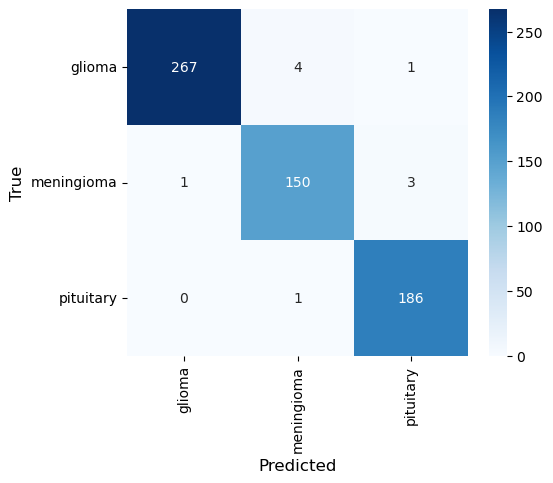

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_=test_images.class_indices.keys()
cm = confusion_matrix(true, y_pred)
fig = plt.figure(figsize=(5.5, 4.5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="Blues",  fmt='g'); 
ax.set_xlabel('Predicted', fontsize=12)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=12)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()